## Forecast value of macroeconomic indicators with Fedot.Industrial

### Fedot.Industrial settings

In [1]:
from fedot_ind.tools.serialisation.path_lib import PROJECT_PATH
from fedot_ind.core.repository.config_repository import DEFAULT_COMPUTE_CONFIG, DEFAULT_AUTOML_LEARNING_CONFIG


DATASET_NAME = 'fred_md'
horizon = 12
METRIC_NAMES = ('mase', 'smape', 'rmse', 'mae')

AUTOML_CONFIG = {'task': 'ts_forecasting',
                 'task_params': {'forecast_length': horizon},
                 'use_automl': True,
                 'optimisation_strategy': {'optimisation_strategy': {'mutation_agent': 'bandit',
                                                                     'mutation_strategy': 'growth_mutation_strategy'},
                                           'optimisation_agent': 'Industrial'}}

API_CONFIG = {'industrial_config': {'problem': 'ts_forecasting',
                                   'task_params': {'forecast_length': horizon}},
              'automl_config': AUTOML_CONFIG,
              'learning_config': {'learning_strategy': 'from_scratch',
                                  'learning_strategy_params': DEFAULT_AUTOML_LEARNING_CONFIG,
                                  'optimisation_loss': {'quality_loss': 'rmse'}},
              'compute_config': DEFAULT_COMPUTE_CONFIG}

### Data Preparation

Dataset [FRED-MD](https://zenodo.org/records/4654833) from [Monash Time Series Forecasting Repository](https://forecastingdata.org/). This dataset contains 107 monthly time series showing a set of macro-economic indicators from the Federal Reserve Bank. It was extracted from the FRED-MD database. The series are differenced and log-transformed as suggested in the literature.

In [ ]:
from examples.example_utils import load_monash_dataset
import pandas as pd


def fred_preprocessing(fred_df: pd.DataFrame) -> pd.DataFrame:
    fred_df.index = pd.date_range(start='1959-01-01', periods=len(fred_df['T1']), freq='MS')
    fred_df = fred_df.reset_index().melt(id_vars='index', var_name='label', value_name='value')
    fred_df.rename(columns={'index': 'datetime'}, inplace=True)
    fred_df['label_num'] = fred_df['label'].str.extract('(\d+)').astype(int)
    fred_df = fred_df.sort_values(by=['label_num', 'datetime']).reset_index(drop=True)
    return fred_df.drop('label_num', axis=1)


economic_df = load_monash_dataset('fred_md')
preprocessed_data = fred_preprocessing(economic_df)
preprocessed_data

2025-01-27 14:34:23,957 - PyTorch version 2.2.2 available.


,datetime,label,value
0,1959-01-01,T1,2437.295898
1,1959-02-01,T1,2446.902100
2,1959-03-01,T1,2462.688965
3,1959-04-01,T1,2478.743896
4,1959-05-01,T1,2493.228027
...,...,...,...
77891,2019-04-01,T107,3608.839111
77892,2019-05-01,T107,3622.253174
77893,2019-06-01,T107,3651.351318
77894,2019-07-01,T107,3673.951416


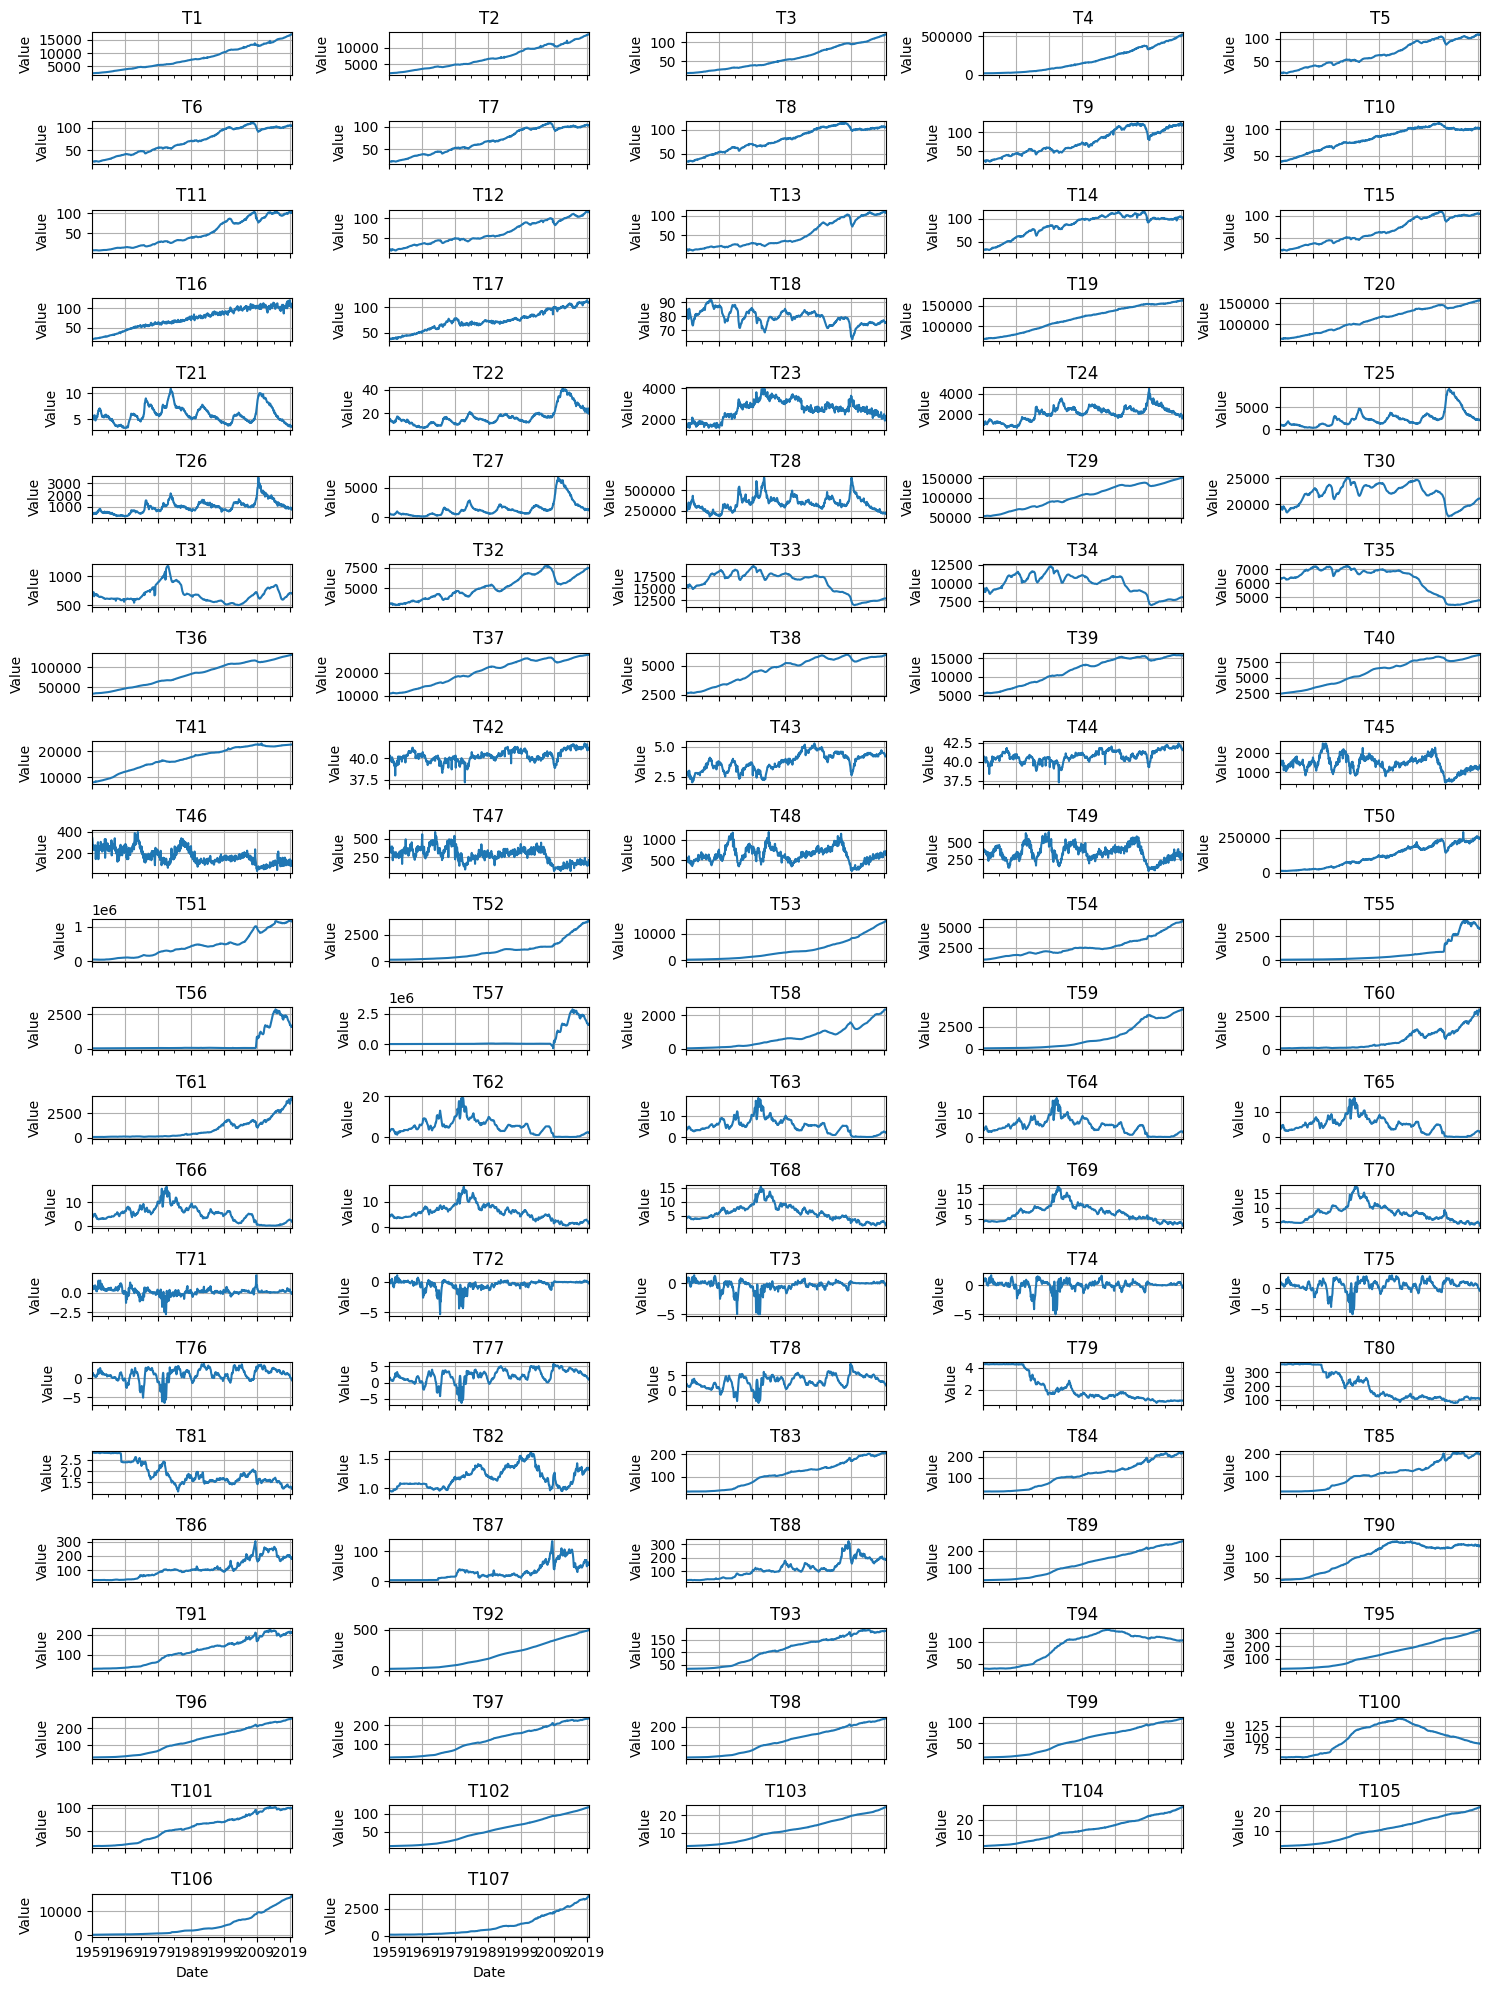

In [3]:
from matplotlib import pyplot as plt


fig, axes = plt.subplots(22, 5, figsize=(15, 20), sharex=True)
axes = axes.flatten()

for idx, column in enumerate(economic_df.columns):
    if idx >= len(axes):
        break
    ax = axes[idx]
    economic_df[column].plot(ax=ax, title=column, legend=False)
    ax.set_xlabel("Date")
    ax.set_ylabel("Value")
    ax.grid(True)

for ax in axes[len(economic_df.columns):]:
    ax.axis('off')

plt.tight_layout()
plt.show()

### API-based approach using AutoML

In [4]:
from fedot_ind.core.architecture.pipelines.abstract_pipeline import ApiTemplate


api_client = ApiTemplate(api_config=API_CONFIG,
                         metric_list=METRIC_NAMES)

id_list = preprocessed_data['label'].unique().tolist()[:2]
data_split = {id: preprocessed_data[preprocessed_data['label'] == id]['value'].values for id in id_list}

fred_results = {}
for index, ts in data_split.items():
    input_data = (ts, ts[-horizon:].flatten())

    dataset_dict = dict(train_data=input_data,
                        test_data=input_data)

    result_dict = api_client.eval(dataset=dataset_dict, finetune=False)
    fred_results.update({index: [result_dict, input_data]})

2025-01-27 14:35:02,575 - --------------------------------------------------
2025-01-27 14:35:02,576 - Initialising Industrial Repository
2025-01-27 14:35:02,576 - -------------------------------------------------
2025-01-27 14:35:02,577 - Initialising Industrial Evolutionary Optimisation params
2025-01-27 14:35:02,616 - --------------------------------------------------
2025-01-27 14:35:02,617 - Initialising Dask Server
Creating Dask Server
2025-01-27 14:35:03,115 - State start
2025-01-27 14:35:03,120 - Found stale lock file and directory 'C:\\Users\\Kaefsky\\AppData\\Local\\Temp\\dask-scratch-space\\scheduler-5y46_15y', purging
2025-01-27 14:35:03,122 - Found stale lock file and directory 'C:\\Users\\Kaefsky\\AppData\\Local\\Temp\\dask-scratch-space\\scheduler-7fwyso7u', purging
2025-01-27 14:35:03,124 - Found stale lock file and directory 'C:\\Users\\Kaefsky\\AppData\\Local\\Temp\\dask-scratch-space\\worker-lefya15m', purging
2025-01-27 14:35:03,126 - Found stale lock file and direc

Generations:   0%|          | 0/10000 [00:00<?, ?gen/s]

2025-01-27 14:35:04,377 - OptunaTuner - Initial graph: {'depth': 1, 'length': 1, 'nodes': [ar]}
ar - {'lag_1': 7, 'lag_2': 12} 
Initial metric: [147.347]
2025-01-27 14:35:11,123 - OptunaTuner - Final graph: {'depth': 1, 'length': 1, 'nodes': [ar]}
ar - {'lag_1': 178.69244494849204, 'lag_2': 326.3806648215293, 'trend': 'ct', 'period': 7, 'seasonal': True, 'deterministic': False}
2025-01-27 14:35:11,125 - OptunaTuner - Final metric: 74.202
2025-01-27 14:35:12,960 - LaggedTransformationImplementation - Window size of lagged transformation was changed by WindowSizeSelector from 0 to 233
2025-01-27 14:35:14,591 - IndustrialDispatcher - 12 individuals out of 13 in previous population were evaluated successfully.
2025-01-27 14:35:21,409 - IndustrialDispatcher - 14 individuals out of 14 in previous population were evaluated successfully.
2025-01-27 14:35:23,500 - IndustrialDispatcher - 5 individuals out of 5 in previous population were evaluated successfully.
2025-01-27 14:35:23,503 - Industri

Generations:   0%|          | 1/10000 [00:20<55:42:49, 20.06s/gen]







Epoch: 1, Steps: 40 | Train Loss: 351.4994126
Updating learning rate to 0.004117055560318814
Epoch: 1, Steps: 40 | Train Loss: 268.5580642
Updating learning rate to 0.004117055560318814
Epoch: 1, Steps: 40 | Train Loss: 152.5411415
Updating learning rate to 0.004117055560318814
2025-01-27 14:35:35,638 - OptunaTuner - Initial graph: {'depth': 1, 'length': 1, 'nodes': [ar]}
ar - {'lag_1': 7, 'lag_2': 12} 
Initial metric: [448.845]


2025-01-27 14:35:53,352 - OptunaTuner - Final graph: {'depth': 1, 'length': 1, 'nodes': [ar]}
ar - {'lag_1': 57.89332793513037, 'lag_2': 745.4572387357828, 'trend': 'n', 'period': 5, 'seasonal': False, 'deterministic': False}
2025-01-27 14:35:53,384 - OptunaTuner - Final metric: 297.648


2025-01-27 14:35:53,817 - OptunaTuner - Initial graph: {'depth': 1, 'length': 1, 'nodes': [ar]}
ar - {'lag_1': 7, 'lag_2': 12} 
Initial metric: [16385.58]
2025-01-27 14:36:13,639 - OptunaTuner - Final graph: {'depth': 1, 'length': 1, 'nodes': [ar]}
ar - {'lag_1': 111.4067529768933, 'lag_2': 682.2553045222026, 'trend': 'c', 'period': 21, 'seasonal': False, 'deterministic': False}
2025-01-27 14:36:13,666 - OptunaTuner - Final metric: 15643.447


2025-01-27 14:36:22,136 - OptunaTuner - Initial graph: {'depth': 1, 'length': 1, 'nodes': [ar]}
ar - {'lag_1': 7, 'lag_2': 12} 
Initial metric: [448.845]


2025-01-27 14:36:37,647 - OptunaTuner - Final graph: {'depth': 1, 'length': 1, 'nodes': [ar]}
ar - {'lag_1': 56.88263038687267, 'lag_2': 560.1759173894967, 'trend': 'c', 'period': 21, 'seasonal': True, 'deterministic': True}
2025-01-27 14:36:37,681 - OptunaTuner - Final metric: 297.785
2025-01-27 14:36:38,103 - OptunaTuner - Initial graph: {'depth': 1, 'length': 1, 'nodes': [ar]}
ar - {'lag_1': 7, 'lag_2': 12} 
Initial metric: [16385.58]
2025-01-27 14:36:58,472 - OptunaTuner - Final graph: {'depth': 1, 'length': 1, 'nodes': [ar]}
ar - {'lag_1': 62.99055249147682, 'lag_2': 115.26668563677265, 'trend': 'c', 'period': 30, 'seasonal': False, 'deterministic': True}
2025-01-27 14:36:58,492 - OptunaTuner - Final metric: 15643.142


2025-01-27 14:37:11,038 - OptunaTuner - Initial graph: {'depth': 1, 'length': 1, 'nodes': [ar]}
ar - {'lag_1': 7, 'lag_2': 12} 
Initial metric: [448.845]
2025-01-27 14:37:31,325 - OptunaTuner - Final graph: {'depth': 1, 'length': 1, 'nodes': [ar]}
ar - {'lag_1': 57.63963631396072, 'lag_2': 655.7731290425262, 'trend': 'ct', 'period': 30, 'seasonal': True, 'deterministic': True}
2025-01-27 14:37:31,334 - OptunaTuner - Final metric: 297.648
2025-01-27 14:37:31,803 - OptunaTuner - Initial graph: {'depth': 1, 'length': 1, 'nodes': [ar]}
ar - {'lag_1': 7, 'lag_2': 12} 
Initial metric: [16385.58]


2025-01-27 14:37:53,079 - OptunaTuner - Final graph: {'depth': 1, 'length': 1, 'nodes': [ar]}
ar - {'lag_1': 111.21728058242977, 'lag_2': 711.7956248813915, 'trend': 'n', 'period': 14, 'seasonal': True, 'deterministic': False}
2025-01-27 14:37:53,094 - OptunaTuner - Final metric: 15643.447


Epoch: 26, Steps: 40 | Train Loss: 4.2640130
Updating learning rate to 0.06365923717500588
Epoch: 26, Steps: 40 | Train Loss: 4.4271246
Updating learning rate to 0.06365923717500588
Epoch: 26, Steps: 40 | Train Loss: 4.5316004
Updating learning rate to 0.06365923717500588


Epoch: 51, Steps: 40 | Train Loss: 4.0245949
Updating learning rate to 0.09918979089640571
Epoch: 51, Steps: 40 | Train Loss: 4.0944093
Updating learning rate to 0.09918979089640571
Epoch: 51, Steps: 40 | Train Loss: 4.0758619
Updating learning rate to 0.09918979089640571


Epoch: 76, Steps: 40 | Train Loss: 4.1039062
Updating learning rate to 0.07996124157779327


Epoch: 76, Steps: 40 | Train Loss: 4.0499118
Updating learning rate to 0.07996124157779327
Epoch: 76, Steps: 40 | Train Loss: 4.0041622
Updating learning rate to 0.07996124157779327


Epoch: 101, Steps: 40 | Train Loss: 4.1401897
Updating learning rate to 0.044736604324739505


Epoch: 101, Steps: 40 | Train Loss: 4.1007291
Updating learning rate to 0.044736604324739505
Epoch: 101, Steps: 40 | Train Loss: 4.0560212
Updating learning rate to 0.044736604324739505


Epoch: 126, Steps: 40 | Train Loss: 4.0129566
Updating learning rate to 0.01232218109759658


Epoch: 126, Steps: 40 | Train Loss: 4.0053283
Updating learning rate to 0.01232218109759658
Epoch: 126, Steps: 40 | Train Loss: 3.9856753
Updating learning rate to 0.01232218109759658
































































100%|██████████| 150/150 [04:16<00:00,  1.71s/it]






100%|██████████| 150/150 [04:17<00:00,  1.72s/it]


100%|██████████| 150/150 [04:18<00:00,  1.72s/it]


2025-01-27 14:39:44,052 - IndustrialDispatcher - 9 individuals out of 9 in previous population were evaluated successfully.
2025-01-27 14:39:45,191 - OptunaTuner - Initial graph: {'depth': 1, 'length': 1, 'nodes': [ar]}
ar - {'lag_1': 7, 'lag_2': 12} 
Initial metric: [868.305]
2025-01-27 14:39:54,951 - OptunaTuner - Final graph: {'depth': 1, 'length': 1, 'nodes': [ar]}
ar - {'lag_1': 96.4860172671241, 'lag_2': 23.395245959711744, 'trend': 'n', 'period': 14, 'seasonal': True, 'deterministic': False}
2025-01-27 14:39:54,965 - OptunaTuner - Final metric: 31.108
2025-01-27 14:40:16,226 - IndustrialDispatcher - 5 individuals out of 5 in previous population were evaluated successfully.
2025-01-27 14:40:16,230 - IndustrialEvoOptimizer - Successful reproduction


Generations:   0%|          | 2/10000 [05:12<501:06:45, 180.44s/gen]

2025-01-27 14:40:17,193 - OptunaTuner - Initial graph: {'depth': 1, 'length': 1, 'nodes': [ar]}
ar - {'lag_1': 7, 'lag_2': 12} 
Initial metric: [147.347]
2025-01-27 14:40:26,723 - OptunaTuner - Final graph: {'depth': 1, 'length': 1, 'nodes': [ar]}
ar - {'lag_1': 25.197897596358708, 'lag_2': 92.60815513257893, 'trend': 'c', 'period': 14, 'seasonal': False, 'deterministic': False}
2025-01-27 14:40:26,742 - OptunaTuner - Final metric: 64.307
2025-01-27 14:40:27,423 - IndustrialDispatcher - 5 individuals out of 5 in previous population were evaluated successfully.
2025-01-27 14:40:29,437 - IndustrialDispatcher - 3 individuals out of 3 in previous population were evaluated successfully.
2025-01-27 14:40:37,499 - IndustrialDispatcher - 2 individuals out of 2 in previous population were evaluated successfully.
2025-01-27 14:40:37,502 - IndustrialEvoOptimizer - Successful reproduction


Generations:   0%|          | 3/10000 [05:34<299:15:41, 107.77s/gen]

2025-01-27 14:40:41,256 - OptunaTuner - Initial graph: {'depth': 1, 'length': 1, 'nodes': [ar]}
ar - {'lag_1': 7, 'lag_2': 12} 
Initial metric: [1088.13]
2025-01-27 14:40:51,379 - OptunaTuner - Final graph: {'depth': 1, 'length': 1, 'nodes': [ar]}
ar - {'lag_1': 47.43707372926922, 'lag_2': 47.201040702607486, 'trend': 'ct', 'period': 30, 'seasonal': False, 'deterministic': True}
2025-01-27 14:40:51,387 - OptunaTuner - Final metric: 46.358
2025-01-27 14:41:00,557 - IndustrialDispatcher - 9 individuals out of 10 in previous population were evaluated successfully.
2025-01-27 14:41:11,982 - IndustrialDispatcher - 7 individuals out of 7 in previous population were evaluated successfully.
2025-01-27 14:41:13,071 - OptunaTuner - Initial graph: {'depth': 1, 'length': 1, 'nodes': [ar]}
ar - {'lag_1': 7, 'lag_2': 12} 
Initial metric: [147.347]
2025-01-27 14:41:23,692 - OptunaTuner - Final graph: {'depth': 1, 'length': 1, 'nodes': [ar]}
ar - {'lag_1': 16.298422744520394, 'lag_2': 4.86727514389843

Generations:   0%|          | 4/10000 [06:22<233:39:47, 84.15s/gen] 

2025-01-27 14:41:27,004 - LaggedTransformationImplementation - Window size of lagged transformation was changed by WindowSizeSelector from 0.0 to 53
2025-01-27 14:41:32,362 - IndustrialDispatcher - 10 individuals out of 10 in previous population were evaluated successfully.
2025-01-27 14:41:37,460 - OptunaTuner - Initial graph: {'depth': 1, 'length': 1, 'nodes': [ar]}
ar - {'lag_1': 7, 'lag_2': 12} 
Initial metric: [147.347]
2025-01-27 14:41:44,145 - OptunaTuner - Final graph: {'depth': 1, 'length': 1, 'nodes': [ar]}
ar - {'lag_1': 67.90350713749842, 'lag_2': 280.2487311251962, 'trend': 'ct', 'period': 14, 'seasonal': True, 'deterministic': False}
2025-01-27 14:41:44,172 - OptunaTuner - Final metric: 47.278
2025-01-27 14:41:59,836 - IndustrialDispatcher - 6 individuals out of 6 in previous population were evaluated successfully.
2025-01-27 14:41:59,839 - IndustrialEvoOptimizer - Successful reproduction


Generations:   0%|          | 5/10000 [06:56<183:51:23, 66.22s/gen]

2025-01-27 14:42:21,682 - IndustrialDispatcher - 7 individuals out of 11 in previous population were evaluated successfully.
2025-01-27 14:42:23,318 - OptunaTuner - Initial graph: {'depth': 1, 'length': 1, 'nodes': [ar]}
ar - {'lag_1': 7, 'lag_2': 12} 
Initial metric: [147.347]
2025-01-27 14:42:31,579 - OptunaTuner - Final graph: {'depth': 1, 'length': 1, 'nodes': [ar]}
ar - {'lag_1': 158.26214745095015, 'lag_2': 90.48011768913673, 'trend': 'ct', 'period': 30, 'seasonal': True, 'deterministic': False}
2025-01-27 14:42:31,584 - OptunaTuner - Final metric: 78.053
2025-01-27 14:42:47,090 - IndustrialDispatcher - 7 individuals out of 8 in previous population were evaluated successfully.
2025-01-27 14:42:49,271 - IndustrialDispatcher - 3 individuals out of 3 in previous population were evaluated successfully.
2025-01-27 14:42:49,274 - IndustrialEvoOptimizer - Successful reproduction


Generations:   0%|          | 6/10000 [07:45<167:57:38, 60.50s/gen]

2025-01-27 14:42:55,914 - OptunaTuner - Initial graph: {'depth': 1, 'length': 1, 'nodes': [ar]}
ar - {'lag_1': 7, 'lag_2': 12} 
Initial metric: [147.347]
2025-01-27 14:42:57,245 - OptunaTuner - Initial graph: {'depth': 1, 'length': 1, 'nodes': [ar]}
ar - {'lag_1': 7, 'lag_2': 12} 
Initial metric: [1567.721]
2025-01-27 14:43:06,813 - OptunaTuner - Final graph: {'depth': 1, 'length': 1, 'nodes': [ar]}
ar - {'lag_1': 149.00033933508385, 'lag_2': 67.32257562086801, 'trend': 'ct', 'period': 30, 'seasonal': True, 'deterministic': False}
2025-01-27 14:43:06,929 - OptunaTuner - Final metric: 54.203
2025-01-27 14:43:12,935 - OptunaTuner - Final graph: {'depth': 1, 'length': 1, 'nodes': [ar]}
ar - {'lag_1': 12.504142272192125, 'lag_2': 267.75641472757275, 'trend': 't', 'period': 14, 'seasonal': False, 'deterministic': True}
2025-01-27 14:43:12,953 - OptunaTuner - Final metric: 37.938
2025-01-27 14:43:13,216 - OptunaTuner - Initial graph: {'depth': 1, 'length': 1, 'nodes': [ar]}
ar - {'lag_1': 7,

2025-01-27 14:43:36,422 - OptunaTuner - Initial graph: {'depth': 1, 'length': 1, 'nodes': [ar]}
ar - {'lag_1': 7, 'lag_2': 12} 
Initial metric: [400.766]
2025-01-27 14:43:44,249 - OptunaTuner - Final graph: {'depth': 1, 'length': 1, 'nodes': [ar]}
ar - {'lag_1': 51.30031181212825, 'lag_2': 123.40952359862364, 'trend': 'c', 'period': 7, 'seasonal': False, 'deterministic': False}
2025-01-27 14:43:44,261 - OptunaTuner - Final metric: 44.748


Epoch: 1, Steps: 40 | Train Loss: 174.4927618
Updating learning rate to 0.004117055560318814


Epoch: 26, Steps: 40 | Train Loss: 4.2479139
Updating learning rate to 0.06365923717500588


Epoch: 51, Steps: 40 | Train Loss: 3.9783875
Updating learning rate to 0.09918979089640571


Epoch: 76, Steps: 40 | Train Loss: 4.0357982
Updating learning rate to 0.07996124157779327


 51%|█████▏    | 77/150 [00:26<00:13,  5.49it/s]

Epoch: 101, Steps: 40 | Train Loss: 4.0209156
Updating learning rate to 0.044736604324739505


Epoch: 126, Steps: 40 | Train Loss: 3.9548372
Updating learning rate to 0.01232218109759658


100%|██████████| 150/150 [00:38<00:00,  3.86it/s]


2025-01-27 14:44:12,745 - IndustrialDispatcher - 9 individuals out of 11 in previous population were evaluated successfully.
2025-01-27 14:44:15,083 - OptunaTuner - Initial graph: {'depth': 1, 'length': 1, 'nodes': [ar]}
ar - {'lag_1': 7, 'lag_2': 12} 
Initial metric: [1088.13]
2025-01-27 14:44:24,838 - OptunaTuner - Final graph: {'depth': 1, 'length': 1, 'nodes': [ar]}
ar - {'lag_1': 116.14486280637689, 'lag_2': 24.8688227898294, 'trend': 'c', 'period': 21, 'seasonal': True, 'deterministic': True}
2025-01-27 14:44:24,844 - OptunaTuner - Final metric: 33.061
2025-01-27 14:44:26,251 - IndustrialDispatcher - 6 individuals out of 7 in previous population were evaluated successfully.
2025-01-27 14:44:26,254 - IndustrialEvoOptimizer - Successful reproduction


Generations:   0%|          | 7/10000 [09:22<201:04:46, 72.44s/gen]

2025-01-27 14:44:33,540 - OptunaTuner - Initial graph: {'depth': 1, 'length': 1, 'nodes': [ar]}
ar - {'lag_1': 7, 'lag_2': 12} 
Initial metric: [147.347]
2025-01-27 14:44:45,516 - OptunaTuner - Final graph: {'depth': 1, 'length': 1, 'nodes': [ar]}
ar - {'lag_1': 25.18222007118152, 'lag_2': 89.18392617320056, 'trend': 't', 'period': 14, 'seasonal': True, 'deterministic': True}
2025-01-27 14:44:45,526 - OptunaTuner - Final metric: 61.127
2025-01-27 14:44:53,422 - OptunaTuner - Initial graph: {'depth': 1, 'length': 1, 'nodes': [ar]}
ar - {'lag_1': 7, 'lag_2': 12} 
Initial metric: [1567.721]
2025-01-27 14:45:02,043 - OptunaTuner - Final graph: {'depth': 1, 'length': 1, 'nodes': [ar]}
ar - {'lag_1': 37.54026318526037, 'lag_2': 163.5939331598292, 'trend': 'c', 'period': 5, 'seasonal': False, 'deterministic': True}
2025-01-27 14:45:02,061 - OptunaTuner - Final metric: 31.894
2025-01-27 14:45:04,926 - MetricsObjective - Objective evaluation error for graph {'depth': 4, 'length': 5, 'nodes': [b

Generations:   0%|          | 8/10000 [12:09<284:00:43, 102.33s/gen]

2025-01-27 14:47:20,674 - OptunaTuner - Initial graph: {'depth': 1, 'length': 1, 'nodes': [ar]}
ar - {'lag_1': 7, 'lag_2': 12} 
Initial metric: [1088.13]
2025-01-27 14:47:33,324 - OptunaTuner - Final graph: {'depth': 1, 'length': 1, 'nodes': [ar]}
ar - {'lag_1': 121.34961018028504, 'lag_2': 291.0267595883904, 'trend': 'ct', 'period': 30, 'seasonal': True, 'deterministic': False}
2025-01-27 14:47:33,335 - OptunaTuner - Final metric: 53.588
2025-01-27 14:49:20,925 - IndustrialDispatcher - 39 individuals out of 48 in previous population were evaluated successfully.
2025-01-27 14:49:34,164 - OptunaTuner - Initial graph: {'depth': 1, 'length': 1, 'nodes': [ar]}
ar - {'lag_1': 7, 'lag_2': 12} 
Initial metric: [1088.13]
2025-01-27 14:49:43,054 - OptunaTuner - Final graph: {'depth': 1, 'length': 1, 'nodes': [ar]}
ar - {'lag_1': 19.479400045799537, 'lag_2': 300.72108186387766, 'trend': 'ct', 'period': 7, 'seasonal': True, 'deterministic': False}
2025-01-27 14:49:43,084 - OptunaTuner - Final met

Generations:   0%|          | 9/10000 [15:28<368:31:02, 132.79s/gen]

2025-01-27 14:50:32,435 - GroupedCondition - Optimisation stopped: Time limit is reached


Generations:   0%|          | 9/10000 [15:28<286:26:53, 103.21s/gen]


2025-01-27 14:50:32,976 - ApiComposer - Model generation finished
2025-01-27 14:50:33,164 - OptunaTuner - Initial graph: {'depth': 1, 'length': 1, 'nodes': [ar]}
ar - {'lag_1': 7, 'lag_2': 12} 
Initial metric: [240.419]
2025-01-27 14:50:39,604 - OptunaTuner - Final graph: {'depth': 1, 'length': 1, 'nodes': [ar]}
ar - {'lag_1': 51.747446964910196, 'lag_2': 308.60074412743114, 'trend': 'c', 'period': 21, 'seasonal': True, 'deterministic': False}
2025-01-27 14:50:39,607 - OptunaTuner - Final metric: 70.013
2025-01-27 14:50:39,887 - FEDOT logger - Final pipeline was fitted
2025-01-27 14:50:39,890 - FEDOT logger - Final pipeline: {'depth': 1, 'length': 1, 'nodes': [glm]}
glm - {'family': 'gaussian', 'link': 'identity', 'nested_label': {'family': 'gamma', 'link': 'log'}}
2025-01-27 14:50:39,891 - MemoryAnalytics - Memory consumption for finish in main session: current 317.2 MiB, max: 757.9 MiB
Creating Dask Server
2025-01-27 14:50:40,917 - AssumptionsHandler - Memory consumption for fitting 

Generations:   0%|          | 0/10000 [00:00<?, ?gen/s]

Epoch: 1, Steps: 40 | Train Loss: 176.8516618
Updating learning rate to 0.004117055560318814


Epoch: 26, Steps: 40 | Train Loss: 4.6979019
Updating learning rate to 0.06365923717500588


 18%|█▊        | 27/150 [00:13<00:23,  5.33it/s]

Epoch: 51, Steps: 40 | Train Loss: 4.0327709
Updating learning rate to 0.09918979089640571


Epoch: 76, Steps: 40 | Train Loss: 4.1852977
Updating learning rate to 0.07996124157779327


Epoch: 101, Steps: 40 | Train Loss: 4.0332075
Updating learning rate to 0.044736604324739505


Epoch: 126, Steps: 40 | Train Loss: 3.9801748
Updating learning rate to 0.01232218109759658


100%|██████████| 150/150 [00:38<00:00,  3.95it/s]


2025-01-27 14:51:20,468 - IndustrialDispatcher - 12 individuals out of 13 in previous population were evaluated successfully.
2025-01-27 14:51:39,295 - OptunaTuner - Initial graph: {'depth': 1, 'length': 1, 'nodes': [ar]}
ar - {'lag_1': 7, 'lag_2': 12} 
Initial metric: [168.696]
2025-01-27 14:51:47,004 - OptunaTuner - Initial graph: {'depth': 1, 'length': 1, 'nodes': [ar]}
ar - {'lag_1': 7, 'lag_2': 12} 
Initial metric: [168.696]
2025-01-27 14:52:09,137 - OptunaTuner - Final graph: {'depth': 1, 'length': 1, 'nodes': [ar]}
ar - {'lag_1': 51.924942159821775, 'lag_2': 700.8827987757022, 'trend': 'ct', 'period': 21, 'seasonal': False, 'deterministic': True}
2025-01-27 14:52:09,480 - OptunaTuner - Final metric: 66.372
2025-01-27 14:52:13,102 - OptunaTuner - Initial graph: {'depth': 1, 'length': 1, 'nodes': [ar]}
ar - {'lag_1': 7, 'lag_2': 12} 
Initial metric: [13693.298]
2025-01-27 14:52:14,929 - OptunaTuner - Final graph: {'depth': 1, 'length': 1, 'nodes': [ar]}
ar - {'lag_1': 51.080575983

Generations:   0%|          | 1/10000 [02:36<434:17:43, 156.36s/gen]

2025-01-27 14:53:34,850 - IndustrialDispatcher - 2 individuals out of 2 in previous population were evaluated successfully.
2025-01-27 14:53:35,444 - OptunaTuner - Initial graph: {'depth': 1, 'length': 1, 'nodes': [ar]}
ar - {'lag_1': 7, 'lag_2': 12} 
Initial metric: [231.787]
2025-01-27 14:53:35,512 - OptunaTuner - Initial graph: {'depth': 1, 'length': 1, 'nodes': [ar]}
ar - {'lag_1': 7, 'lag_2': 12} 
Initial metric: [231.787]
2025-01-27 14:53:48,315 - OptunaTuner - Final graph: {'depth': 1, 'length': 1, 'nodes': [ar]}
ar - {'lag_1': 148.6809514375511, 'lag_2': 62.224683187409106, 'trend': 't', 'period': 14, 'seasonal': True, 'deterministic': False}
2025-01-27 14:53:48,556 - OptunaTuner - Final metric: 70.613
2025-01-27 14:53:50,688 - OptunaTuner - Final graph: {'depth': 1, 'length': 1, 'nodes': [ar]}
ar - {'lag_1': 65.97800185051332, 'lag_2': 267.4278431614513, 'trend': 'n', 'period': 5, 'seasonal': True, 'deterministic': True}
2025-01-27 14:53:50,713 - OptunaTuner - Final metric: 58

Generations:   0%|          | 2/10000 [03:12<237:44:44, 85.61s/gen] 

2025-01-27 14:53:58,279 - IndustrialDispatcher - 5 individuals out of 5 in previous population were evaluated successfully.
2025-01-27 14:54:09,450 - IndustrialDispatcher - 3 individuals out of 3 in previous population were evaluated successfully.
2025-01-27 14:54:19,123 - IndustrialDispatcher - 2 individuals out of 2 in previous population were evaluated successfully.
2025-01-27 14:54:19,126 - IndustrialEvoOptimizer - Successful reproduction


Generations:   0%|          | 3/10000 [03:38<161:55:46, 58.31s/gen]

2025-01-27 14:54:23,645 - IndustrialDispatcher - 4 individuals out of 5 in previous population were evaluated successfully.
2025-01-27 14:54:26,576 - IndustrialDispatcher - 2 individuals out of 3 in previous population were evaluated successfully.


Generations:   0%|          | 4/10000 [03:46<106:30:56, 38.36s/gen]

2025-01-27 14:54:40,549 - IndustrialDispatcher - 6 individuals out of 6 in previous population were evaluated successfully.
2025-01-27 14:54:42,202 - OptunaTuner - Initial graph: {'depth': 1, 'length': 1, 'nodes': [ar]}
ar - {'lag_1': 7, 'lag_2': 12} 
Initial metric: [1282.531]
2025-01-27 14:54:51,418 - OptunaTuner - Final graph: {'depth': 1, 'length': 1, 'nodes': [ar]}
ar - {'lag_1': 38.458894779626156, 'lag_2': 273.41070764514757, 'trend': 'n', 'period': 7, 'seasonal': False, 'deterministic': False}
2025-01-27 14:54:51,427 - OptunaTuner - Final metric: 97.230
2025-01-27 14:55:05,037 - IndustrialDispatcher - 10 individuals out of 10 in previous population were evaluated successfully.
2025-01-27 14:55:05,930 - OptunaTuner - Initial graph: {'depth': 1, 'length': 1, 'nodes': [ar]}
ar - {'lag_1': 7, 'lag_2': 12} 
Initial metric: [231.787]
2025-01-27 14:55:15,862 - OptunaTuner - Final graph: {'depth': 1, 'length': 1, 'nodes': [ar]}
ar - {'lag_1': 2.2991458476422793, 'lag_2': 323.5453386179

Generations:   0%|          | 5/10000 [04:36<118:07:11, 42.54s/gen]

2025-01-27 14:55:31,595 - IndustrialDispatcher - 7 individuals out of 7 in previous population were evaluated successfully.
2025-01-27 14:55:40,079 - LaggedTransformationImplementation - Window size of lagged transformation was changed by WindowSizeSelector from 0.0 to 125
2025-01-27 14:55:42,330 - IndustrialDispatcher - 5 individuals out of 5 in previous population were evaluated successfully.
2025-01-27 14:55:42,333 - IndustrialEvoOptimizer - Successful reproduction


Generations:   0%|          | 6/10000 [05:01<101:58:32, 36.73s/gen]

2025-01-27 14:56:56,054 - IndustrialDispatcher - 27 individuals out of 31 in previous population were evaluated successfully.
2025-01-27 14:56:58,041 - OptunaTuner - Initial graph: {'depth': 1, 'length': 1, 'nodes': [ar]}
ar - {'lag_1': 7, 'lag_2': 12} 
Initial metric: [427.919]
2025-01-27 14:57:12,923 - OptunaTuner - Final graph: {'depth': 1, 'length': 1, 'nodes': [ar]}
ar - {'lag_1': 2.074030152187542, 'lag_2': 132.07032220853063, 'trend': 'n', 'period': 21, 'seasonal': True, 'deterministic': True}
2025-01-27 14:57:12,931 - OptunaTuner - Final metric: 61.101
2025-01-27 14:57:23,032 - IndustrialDispatcher - 11 individuals out of 12 in previous population were evaluated successfully.
2025-01-27 14:57:39,445 - IndustrialDispatcher - 8 individuals out of 10 in previous population were evaluated successfully.
2025-01-27 14:57:39,449 - IndustrialEvoOptimizer - Successful reproduction


Generations:   0%|          | 7/10000 [06:58<174:57:09, 63.03s/gen]

2025-01-27 14:58:11,500 - OptunaTuner - Initial graph: {'depth': 1, 'length': 1, 'nodes': [ar]}
ar - {'lag_1': 7, 'lag_2': 12} 
Initial metric: [1415.023]
2025-01-27 14:58:20,052 - OptunaTuner - Final graph: {'depth': 1, 'length': 1, 'nodes': [ar]}
ar - {'lag_1': 179.96213145277113, 'lag_2': 275.4249193543218, 'trend': 'n', 'period': 14, 'seasonal': False, 'deterministic': False}
2025-01-27 14:58:20,056 - OptunaTuner - Final metric: 64.928
2025-01-27 14:58:24,669 - OptunaTuner - Initial graph: {'depth': 1, 'length': 1, 'nodes': [ar]}
ar - {'lag_1': 7, 'lag_2': 12} 
Initial metric: [231.787]
2025-01-27 14:58:32,428 - OptunaTuner - Final graph: {'depth': 1, 'length': 1, 'nodes': [ar]}
ar - {'lag_1': 186.65323990007812, 'lag_2': 93.70802612527027, 'trend': 'n', 'period': 365, 'seasonal': False, 'deterministic': False}
2025-01-27 14:58:32,431 - OptunaTuner - Final metric: 81.419
2025-01-27 14:58:43,004 - OptunaTuner - Initial graph: {'depth': 1, 'length': 1, 'nodes': [ar]}
ar - {'lag_1': 7

Generations:   0%|          | 8/10000 [09:46<267:46:24, 96.48s/gen]

2025-01-27 15:01:35,380 - OptunaTuner - Initial graph: {'depth': 1, 'length': 1, 'nodes': [ar]}
ar - {'lag_1': 7, 'lag_2': 12} 
Initial metric: [231.787]
2025-01-27 15:01:44,887 - OptunaTuner - Final graph: {'depth': 1, 'length': 1, 'nodes': [ar]}
ar - {'lag_1': 2.220393397899704, 'lag_2': 153.2158743327939, 'trend': 'ct', 'period': 365, 'seasonal': True, 'deterministic': True}
2025-01-27 15:01:44,905 - OptunaTuner - Final metric: 83.805
2025-01-27 15:02:08,040 - OptunaTuner - Initial graph: {'depth': 1, 'length': 1, 'nodes': [ar]}
ar - {'lag_1': 7, 'lag_2': 12} 
Initial metric: [507.36]
2025-01-27 15:02:14,855 - OptunaTuner - Final graph: {'depth': 1, 'length': 1, 'nodes': [ar]}
ar - {'lag_1': 125.33581263148358, 'lag_2': 43.52768812502357, 'trend': 'c', 'period': 21, 'seasonal': False, 'deterministic': False}
2025-01-27 15:02:14,876 - OptunaTuner - Final metric: 105.164
2025-01-27 15:02:20,525 - OptunaTuner - Initial graph: {'depth': 1, 'length': 1, 'nodes': [ar]}
ar - {'lag_1': 7, '

Generations:   0%|          | 9/10000 [12:28<324:40:17, 116.99s/gen]

2025-01-27 15:03:49,805 - OptunaTuner - Initial graph: {'depth': 1, 'length': 1, 'nodes': [ar]}
ar - {'lag_1': 7, 'lag_2': 12} 
Initial metric: [231.787]
2025-01-27 15:03:56,302 - OptunaTuner - Final graph: {'depth': 1, 'length': 1, 'nodes': [ar]}
ar - {'lag_1': 6.592906741953731, 'lag_2': 325.8117074792316, 'trend': 'ct', 'period': 365, 'seasonal': False, 'deterministic': True}
2025-01-27 15:03:56,317 - OptunaTuner - Final metric: 87.253
2025-01-27 15:03:59,048 - OptunaTuner - Initial graph: {'depth': 1, 'length': 1, 'nodes': [ar]}
ar - {'lag_1': 7, 'lag_2': 12} 
Initial metric: [1583.24]
2025-01-27 15:04:08,285 - OptunaTuner - Final graph: {'depth': 1, 'length': 1, 'nodes': [ar]}
ar - {'lag_1': 53.148458837271, 'lag_2': 249.84922031184163, 'trend': 'c', 'period': 7, 'seasonal': False, 'deterministic': True}
2025-01-27 15:04:08,307 - OptunaTuner - Final metric: 121.258
2025-01-27 15:04:51,827 - IndustrialDispatcher - 47 individuals out of 49 in previous population were evaluated succe

Generations:   0%|          | 10/10000 [14:17<317:36:01, 114.45s/gen]

2025-01-27 15:04:58,548 - GroupedCondition - Optimisation stopped: Time limit is reached


Generations:   0%|          | 10/10000 [14:17<237:58:43, 85.76s/gen] 


2025-01-27 15:04:59,094 - ApiComposer - Model generation finished
2025-01-27 15:04:59,407 - OptunaTuner - Initial graph: {'depth': 1, 'length': 1, 'nodes': [ar]}
ar - {'lag_1': 7, 'lag_2': 12} 
Initial metric: [297.561]
2025-01-27 15:05:05,930 - OptunaTuner - Final graph: {'depth': 1, 'length': 1, 'nodes': [ar]}
ar - {'lag_1': 186.42642091544815, 'lag_2': 293.3611938980164, 'trend': 't', 'period': 30, 'seasonal': False, 'deterministic': False}
2025-01-27 15:05:05,933 - OptunaTuner - Final metric: 115.169
2025-01-27 15:05:06,247 - FEDOT logger - Final pipeline was fitted
2025-01-27 15:05:06,251 - FEDOT logger - Final pipeline: {'depth': 2, 'length': 2, 'nodes': [glm, smoothing]}
glm - {'family': 'gaussian', 'link': 'identity'}
smoothing - {'window_size': 19}
2025-01-27 15:05:06,252 - MemoryAnalytics - Memory consumption for finish in main session: current 265.2 MiB, max: 695.3 MiB


In [ ]:
metrics_list = []

for label, data in fred_results.items():
    metrics = data[0]['metrics']
    metrics['label'] = label
    metrics_list.append(metrics)

metrics_df = pd.concat(metrics_list, ignore_index=True).set_index(keys='label')
metrics_df

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

border = 200
fig, axes = plt.subplots(nrows=22, ncols=5, figsize=(15, 20), sharex=True, sharey=False)
axes = axes.flatten()

for idx, (label, data) in enumerate(fred_results.items()):
    if idx >= len(axes):
        break

    result_dict = data[0]
    real_values = data[1][0]
    eigen = result_dict['labels']

    if len(real_values) > border:
        real_values = real_values[-border:]
    indicies = np.arange(real_values.shape[0])

    ax = axes[idx]

    ax.plot(real_values, label='Real values', color='blue')
    real_last_value = real_values[-horizon - 1]
    ax.plot(indicies[-horizon - 1:],
            np.insert(eigen, 0, real_last_value), label='Forecast', color='orange')

    ax.set_title(label)
    ax.set_xlabel("Date")
    ax.set_ylabel("Value")
    ax.grid(True)
    ax.legend()

for ax in axes[len(fred_results):]:
    ax.axis('off')
    
plt.tight_layout()
plt.show()